<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
# DESCARGO UN DATA SET CON TEXTOS CLASIFICADOS SEGUN EL SENTIMIENTO

# !pip install datasets
# from datasets import load_dataset

# emotion_dataset = load_dataset("emotion")

In [2]:
# emotion_dataset.set_format(type="pandas")
# train = emotion_dataset["train"][:]
# test = emotion_dataset["test"][:]
# val = emotion_dataset["validation"][:]

In [3]:
# # 0: tristeza
# # 1: felicidad
# # 3: ira

# sadness = train[train['label']==0]['text'][:100]
# joy = train[train['label']==1]['text'][:100]
# anger = train[train['label']==3]['text'][:100]


In [4]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

     |████████████████████████████████| 6.4 MB 1.0 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 10.1 MB 45.0 MB/s 
     |████████████████████████████████| 653 kB 51.3 MB/s 
     |████████████████████████████████| 451 kB 43.1 MB/s 
     |████████████████████████████████| 342 kB 5.2 MB/s 


In [5]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [6]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2022-04-04 01:22:14 INFO: Downloading default packages for language: es (Spanish)...


2022-04-04 01:24:06 INFO: Finished downloading models and saved to /root/stanza_resources.
2022-04-04 01:24:06 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2022-04-04 01:24:06 INFO: Use device: cpu
2022-04-04 01:24:06 INFO: Loading: tokenize
2022-04-04 01:24:07 INFO: Loading: mwt
2022-04-04 01:24:07 INFO: Loading: pos
2022-04-04 01:24:07 INFO: Loading: lemma
2022-04-04 01:24:07 INFO: Loading: depparse
2022-04-04 01:24:07 INFO: Loading: ner
2022-04-04 01:24:09 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [7]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [8]:
text = "personas Ideas! estás cosas y los peces y los muercielagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los muercielagos'

In [9]:
# Ejemplo de como fuciona
text = "hola personas Ideas! estás cosas y los peces y los muercielagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("Lematización de cada token:")
for token in tokes:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los muercielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[muercielagos, 'muercielago']


### 3 - Diccionario de entrada

In [11]:
# # Dataset en formato JSON que representa las posibles preguntas (patterns)
# # y las posibles respuestas por categoría (tag)
# dataset = {"intents": [
#              {"tag": "Sadness",
#               "patterns": [str(list(sadness))],
#               "responses": ["You are sad :("],
#              },
#              {"tag": "Joy",
#               "patterns": [str(list(joy))],
#               "responses": ["You are happy :)"]
#              },
#             {"tag": "Anger",
#               "patterns": [str(list(anger))],
#               "responses": ["You are in anger >:|"]
#             }
# ]}

sadness = ["Cometí muchos errores ultimamente",
"Me siento solo y aburrido, no se que hacer",
"me siento triste, no puedo parar de llorar",
"estoy llorando",
"me equivoqué otra vez",
"me siento mal, no me puedo recuperar",
"estoy en soledad, nada me hace sentir bien",
"estoy desanimado en el trabajo"]

joy = ["me siento muy feliz y lleno de energia",
"podría cantar de felicidad",
"estoy siendo muy productivo ultimamente",
"en el trabajo me esta yendo muy bien",
"estoy acompañado por buenas personas",
"tome excelentes decisiones en el ultimo tiempo",
"estoy sonriente",
"no paro de sonreir",
"me encanta caminar escuchando musica"]

# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
dataset = {"intents": [
             {"tag": "Sadness",
              "patterns": sadness,
              "responses": ["You are sad :("],
             },
             {"tag": "Joy",
              "patterns": joy,
              "responses": ["You are happy :)"]
             }
]}



### 4 - Preprocesamiento y armado del dataset

In [12]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [13]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['aburrido', 'acompanado', 'bien', 'buen', 'caminar', 'cantar', 'cometer', 'de', 'decisión', 'desanimado', 'el', 'en', 'encantar', 'energia', 'equivocar', 'error', 'escuchar', 'estar', 'este', 'excelente', 'felicidad', 'feliz', 'hacer', 'ir', 'lleno', 'llorar', 'mal', 'mucho', 'musica', 'nada', 'no', 'otro', 'parar', 'paro', 'persona', 'poder', 'por', 'productivo', 'que', 'recuperar', 'sentir', 'ser', 'soledad', 'solo', 'sonreir', 'sonriente', 'tiempo', 'tomar', 'trabajo', 'triste', 'ultimamente', 'ultimo', 'vez', 'y', 'yo', 'él']
classes: ['Joy', 'Sadness']
doc_X: ['Cometí muchos errores ultimamente', 'Me siento solo y aburrido, no se que hacer', 'me siento triste, no puedo parar de llorar', 'estoy llorando', 'me equivoqué otra vez', 'me siento mal, no me puedo recuperar', 'estoy en soledad, nada me hace sentir bien', 'estoy desanimado en el trabajo', 'me siento muy feliz y lleno de energia', 'podría cantar de felicidad', 'estoy siendo muy productivo ultimamente', 'en el trabaj

In [15]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 56


In [16]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 2


In [17]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] y: [0, 1]
X: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1] y: [0, 1]
X: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0] y: [0, 1]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0] y: [0, 1]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

### 5 - Entrenamiento del modelo

In [18]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (56,) output: 2


In [19]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(32, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1824      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                1

In [20]:
hist = model.fit(x=train_X, y=train_y, epochs=500)

Epoch 1/500
1/1 [==============================] - 1s 930ms/step - loss: 0.6922 - accuracy: 0.4706
Epoch 2/500
1/1 [==============================] - 0s 10ms/step - loss: 0.6840 - accuracy: 0.5294
Epoch 3/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7065 - accuracy: 0.5294
Epoch 4/500
1/1 [==============================] - 0s 11ms/step - loss: 0.6914 - accuracy: 0.5882
Epoch 5/500
1/1 [==============================] - 0s 12ms/step - loss: 0.6566 - accuracy: 0.8235
Epoch 6/500
1/1 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.6471
Epoch 7/500
1/1 [==============================] - 0s 9ms/step - loss: 0.6742 - accuracy: 0.4706
Epoch 8/500
1/1 [==============================] - 0s 9ms/step - loss: 0.7188 - accuracy: 0.3529
Epoch 9/500
1/1 [==============================] - 0s 8ms/step - loss: 0.6899 - accuracy: 0.4118
Epoch 10/500
1/1 [==============================] - 0s 11ms/step - loss: 0.6685 - accuracy: 0.5882
Epoch 11/500
1/1 [====

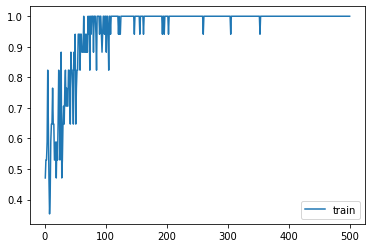

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [22]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [23]:
def text_to_tokens(text): 
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [ ]:
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Perdón, no comprendo la pregunta.")
    

BOT: You are happy :)
BOT: You are sad :(


/usr/local/lib/python3.7/dist-packages/stanza/models/common/beam.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenize

BOT: You are happy :)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['voy', 'caminando', 'triste', 'a', 'el', 'trabajo']
Entities: []
  This is separate from the ipykernel package so we can avoid doing imports until


BOT: You are happy :)
BOT: You are sad :(
BOT: You are happy :)
BOT: You are happy :)
BOT: You are sad :(
BOT: You are sad :(
BOT: You are sad :(
BOT: You are sad :(
BOT: You are happy :)


### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words